# Transfer Learning
The objective in this notebook is to use **transfer learning** along with data augmentation pipelines from the previous
notebook to see if we can get a better performance and use that instead of our custom CNN. We'll use different backbones such as
- ResNet34
- DenseNet
- EfficientNet
- GoogLeNet
- VGG

In [1]:
import os
import pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BRISC_DATA_PATH = pathlib.Path('../../brisc2025')
CLASSIFICATION_PATH = BRISC_DATA_PATH / 'classification_task'
TRAIN_DATA_PATH = CLASSIFICATION_PATH / 'train'
TEST_DATA_PATH = CLASSIFICATION_PATH / 'test'

## Data Loading and Preprocessing

In [3]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [4]:
train_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.RandomCrop((224, 224)),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

test_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [5]:
to_tensor = lambda x: torch.tensor(x, dtype=torch.long)

In [6]:
train_dataset = ImageFolder(TRAIN_DATA_PATH, transform=train_pipeline, target_transform=to_tensor)
test_dataset = ImageFolder(TEST_DATA_PATH, transform=test_pipeline, target_transform=to_tensor)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Model Training using Transfer Learning
There are two types of transfer learning techniques: **Fine Tuning** and **Freezing** (using the pretrained model as a feature extractor).

For this tasks due to the size of our training dataset (5K images) we'll go to the second one, the first option is not feasible.

Since all the pretrained models in TorchVision where trained on **ImageNet** they expect 3 channel input images (RGB) and their output consist of 1000 classes. We need to adapt them to out data:
- 1 channel input images
- 4 output classes

In [8]:
from torch import nn, optim
from torchvision import models

In [9]:
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.mps.is_available() else
    'cpu'
)

device

'mps'

In [38]:
def adapt_model(model, in_channels: int = 1, n_classes: int = 4):
    old_conv = model.features[0][0]

    new_conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=old_conv.bias is not None
    )
    
    new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
    
    model.features[0][0] = new_conv
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=n_classes)
    )

    return model

In [10]:
def get_correct_predictions(preds, target):
    preds = torch.softmax(preds, dim=1) # Activation for multi-class problems
    return (preds.argmax(1) == target).float().sum().item()

In [11]:
def train_loop(model, dataloader, loss_fn, optimizer, device='cpu'):
    train_loss, correct = 0, 0
    num_batches = len(dataloader)
    total_samples = len(dataloader.dataset)

    model.train()

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        logits = model(image) # Assuming our loss expects logits
        loss = loss_fn(logits, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # Using not scheduler

        train_loss += loss.item() 
        correct += get_correct_predictions(logits, label)

    epoch_loss = train_loss / num_batches
    accuracy = correct / total_samples

    print(f'Train Loss: {epoch_loss:.4f} - Train Accuracy: {accuracy:.4f}')

    return epoch_loss, accuracy

In [12]:
def test_loop(model, dataloader, loss_fn, device='cpu'):
    test_loss, correct = 0, 0
    num_batches = len(dataloader)
    total_samples = len(dataloader.dataset)

    model.eval()
    
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            logits = model(image)
            test_loss += loss_fn(logits, label).item()
            correct += get_correct_predictions(logits, label)

    epoch_loss = test_loss / num_batches
    accuracy = correct / total_samples

    print(f'Test Loss: {epoch_loss:.4f} - Test Accuracy: {accuracy:.4f}')

    return epoch_loss, accuracy

In [13]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

### EfficientNet B0

In [57]:
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

In [58]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

model = model.to(device)

In [59]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.8')):
        param.requires_grad = False

In [60]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

5124

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [66]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.6740 - Train Accuracy: 0.7788
Test Loss: 0.5939 - Test Accuracy: 0.7660
Epoch 2
---------------
Train Loss: 0.4589 - Train Accuracy: 0.8442
Test Loss: 0.4922 - Test Accuracy: 0.8060
Epoch 3
---------------
Train Loss: 0.4146 - Train Accuracy: 0.8556
Test Loss: 0.4599 - Test Accuracy: 0.8110
Epoch 4
---------------
Train Loss: 0.3746 - Train Accuracy: 0.8652
Test Loss: 0.4677 - Test Accuracy: 0.8130
Epoch 5
---------------
Train Loss: 0.3604 - Train Accuracy: 0.8740
Test Loss: 0.4163 - Test Accuracy: 0.8280
Epoch 6
---------------
Train Loss: 0.3478 - Train Accuracy: 0.8774
Test Loss: 0.3930 - Test Accuracy: 0.8400
Epoch 7
---------------
Train Loss: 0.3508 - Train Accuracy: 0.8776
Test Loss: 0.3759 - Test Accuracy: 0.8460
Epoch 8
---------------
Train Loss: 0.3360 - Train Accuracy: 0.8804
Test Loss: 0.3771 - Test Accuracy: 0.8490
Epoch 9
---------------
Train Loss: 0.3296 - Train Accuracy: 0.8810
Test Loss: 0.3802 - Test Accuracy: 0.8500
Epoch 10
-

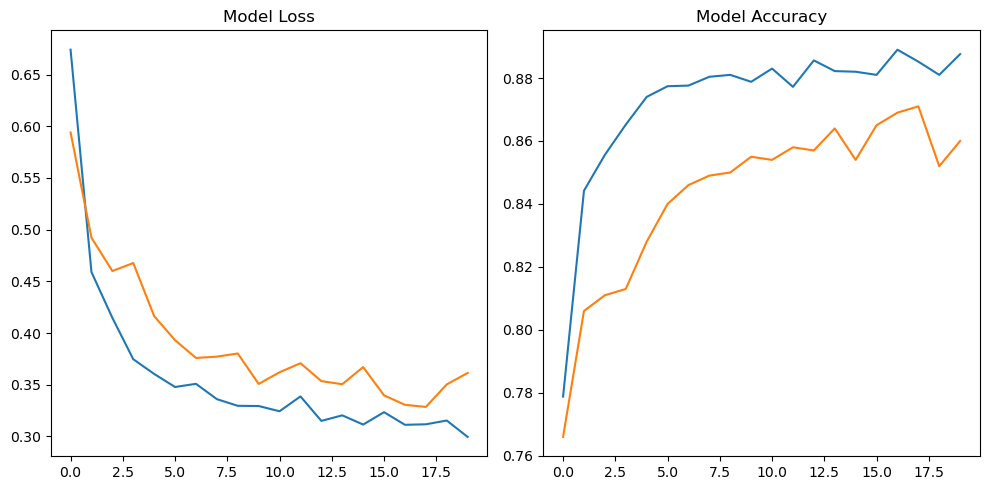

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### ResNet

In [144]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

In [145]:
old_conv = model.conv1

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.conv1 = new_conv

model.fc = nn.Linear(in_features=512, out_features=4, bias=True)

model = model.to(device)

In [146]:
for name, param in model.named_parameters():
    if not name.startswith(('fc', 'layer4.2')):
        param.requires_grad = False

In [147]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

4722692

In [148]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [149]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.4415 - Train Accuracy: 0.8384
Test Loss: 0.2717 - Test Accuracy: 0.9120
Epoch 2
---------------
Train Loss: 0.2376 - Train Accuracy: 0.9148
Test Loss: 0.2126 - Test Accuracy: 0.9260
Epoch 3
---------------
Train Loss: 0.1995 - Train Accuracy: 0.9294
Test Loss: 0.1542 - Test Accuracy: 0.9450
Epoch 4
---------------
Train Loss: 0.1643 - Train Accuracy: 0.9432
Test Loss: 0.1643 - Test Accuracy: 0.9380
Epoch 5
---------------
Train Loss: 0.1375 - Train Accuracy: 0.9534
Test Loss: 0.1347 - Test Accuracy: 0.9500
Epoch 6
---------------
Train Loss: 0.1255 - Train Accuracy: 0.9540
Test Loss: 0.1674 - Test Accuracy: 0.9400
Epoch 7
---------------
Train Loss: 0.1052 - Train Accuracy: 0.9656
Test Loss: 0.1348 - Test Accuracy: 0.9520
Epoch 8
---------------
Train Loss: 0.0983 - Train Accuracy: 0.9658
Test Loss: 0.1137 - Test Accuracy: 0.9640
Epoch 9
---------------
Train Loss: 0.0900 - Train Accuracy: 0.9688
Test Loss: 0.0945 - Test Accuracy: 0.9640
Epoch 10
-

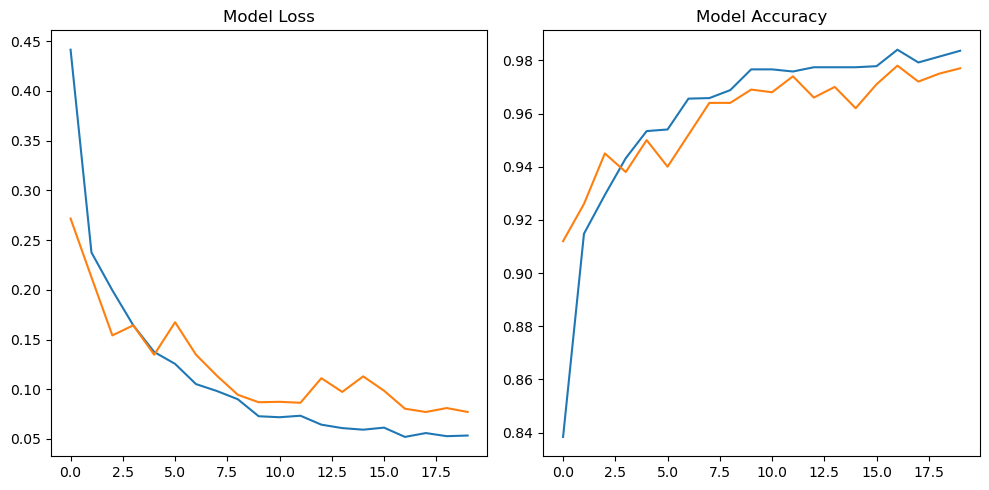

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### DenseNet

In [163]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

In [164]:
old_conv = model.features.conv0

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features.conv0 = new_conv
model.classifier = nn.Linear(in_features=1024, out_features=4, bias=True)

model = model.to(device)

In [165]:
for param in model.features.parameters():
    param.requires_grad = False

In [166]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

4100

In [167]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [168]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.7128 - Train Accuracy: 0.7546
Test Loss: 0.6007 - Test Accuracy: 0.7650
Epoch 2
---------------
Train Loss: 0.4516 - Train Accuracy: 0.8458
Test Loss: 0.5373 - Test Accuracy: 0.7850
Epoch 3
---------------
Train Loss: 0.3956 - Train Accuracy: 0.8586
Test Loss: 0.4899 - Test Accuracy: 0.8040
Epoch 4
---------------
Train Loss: 0.3672 - Train Accuracy: 0.8702
Test Loss: 0.4655 - Test Accuracy: 0.8070
Epoch 5
---------------
Train Loss: 0.3411 - Train Accuracy: 0.8856
Test Loss: 0.4976 - Test Accuracy: 0.8030
Epoch 6
---------------
Train Loss: 0.3275 - Train Accuracy: 0.8858
Test Loss: 0.3904 - Test Accuracy: 0.8520
Epoch 7
---------------
Train Loss: 0.3203 - Train Accuracy: 0.8830
Test Loss: 0.3820 - Test Accuracy: 0.8440
Epoch 8
---------------
Train Loss: 0.3098 - Train Accuracy: 0.8884
Test Loss: 0.3874 - Test Accuracy: 0.8450
Epoch 9
---------------
Train Loss: 0.2945 - Train Accuracy: 0.8944
Test Loss: 0.4016 - Test Accuracy: 0.8400
Epoch 10
-

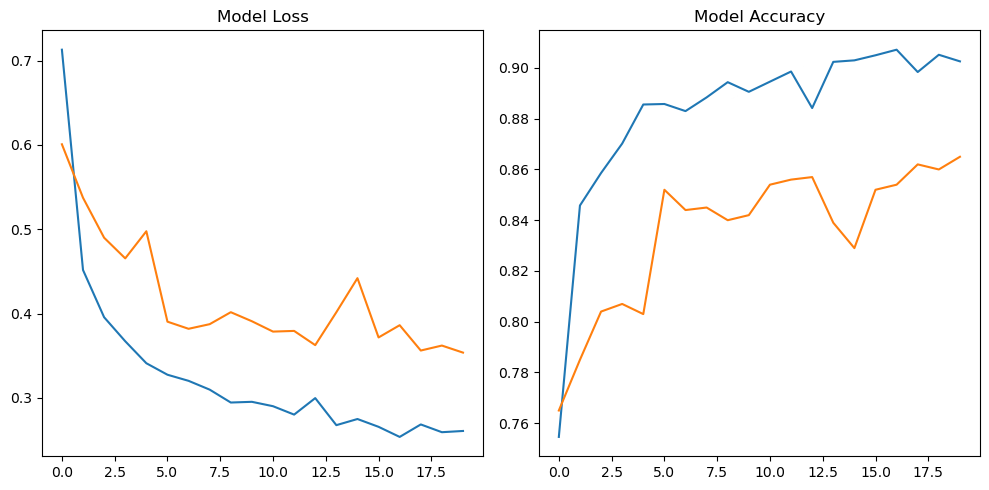

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### EfficientNet B1

In [259]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)

In [260]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

model = model.to(device)

In [261]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.8')):
        param.requires_grad = False

In [262]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

417284

In [263]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [264]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.5536 - Train Accuracy: 0.8214
Test Loss: 0.4112 - Test Accuracy: 0.8130
Epoch 2
---------------
Train Loss: 0.3262 - Train Accuracy: 0.8838
Test Loss: 0.3163 - Test Accuracy: 0.8720
Epoch 3
---------------
Train Loss: 0.2885 - Train Accuracy: 0.8934
Test Loss: 0.2735 - Test Accuracy: 0.8830
Epoch 4
---------------
Train Loss: 0.2575 - Train Accuracy: 0.9006
Test Loss: 0.2233 - Test Accuracy: 0.9050
Epoch 5
---------------
Train Loss: 0.2339 - Train Accuracy: 0.9142
Test Loss: 0.2166 - Test Accuracy: 0.9080
Epoch 6
---------------
Train Loss: 0.2110 - Train Accuracy: 0.9182
Test Loss: 0.2078 - Test Accuracy: 0.9040
Epoch 7
---------------
Train Loss: 0.2088 - Train Accuracy: 0.9208
Test Loss: 0.1891 - Test Accuracy: 0.9150
Epoch 8
---------------
Train Loss: 0.1941 - Train Accuracy: 0.9278
Test Loss: 0.1786 - Test Accuracy: 0.9240
Epoch 9
---------------
Train Loss: 0.1818 - Train Accuracy: 0.9310
Test Loss: 0.1783 - Test Accuracy: 0.9210
Epoch 10
-

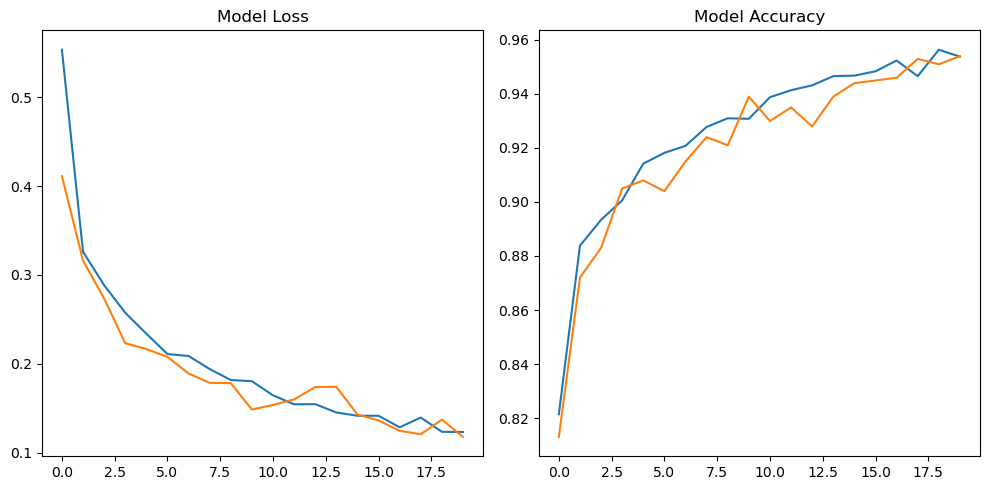

In [265]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### MobileNet

In [12]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [13]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

model = model.to(device)

In [14]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.8')):
        param.requires_grad = False

In [15]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

59396

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.6234 - Train Accuracy: 0.7978
Test Loss: 0.4092 - Test Accuracy: 0.8270
Epoch 2
---------------
Train Loss: 0.3242 - Train Accuracy: 0.8920
Test Loss: 0.3390 - Test Accuracy: 0.8580
Epoch 3
---------------
Train Loss: 0.2646 - Train Accuracy: 0.9102
Test Loss: 0.3106 - Test Accuracy: 0.8690
Epoch 4
---------------
Train Loss: 0.2401 - Train Accuracy: 0.9160
Test Loss: 0.2408 - Test Accuracy: 0.9010
Epoch 5
---------------
Train Loss: 0.2027 - Train Accuracy: 0.9262
Test Loss: 0.2029 - Test Accuracy: 0.9260
Epoch 6
---------------
Train Loss: 0.1688 - Train Accuracy: 0.9374
Test Loss: 0.1807 - Test Accuracy: 0.9290
Epoch 7
---------------
Train Loss: 0.1603 - Train Accuracy: 0.9400
Test Loss: 0.1698 - Test Accuracy: 0.9370
Epoch 8
---------------
Train Loss: 0.1454 - Train Accuracy: 0.9510
Test Loss: 0.1574 - Test Accuracy: 0.9400
Epoch 9
---------------
Train Loss: 0.1375 - Train Accuracy: 0.9514
Test Loss: 0.1290 - Test Accuracy: 0.9540
Epoch 10
-

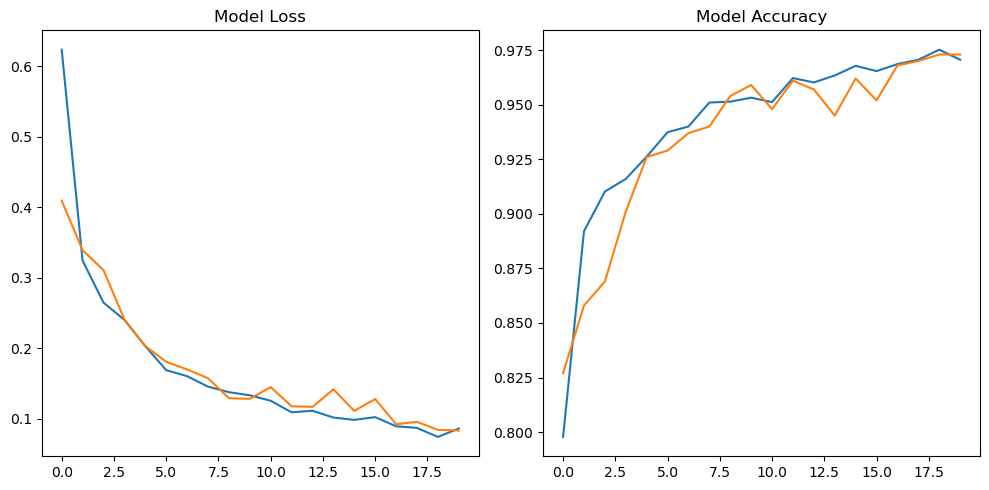

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### ConvNeXt

In [40]:
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)

In [42]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier[2] = nn.Linear(in_features=768, out_features=4, bias=True)

model = model.to(device)

In [43]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.7.2.block.5')):
        param.requires_grad = False

In [44]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

2364676

In [38]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, train_accuracy = train_loop(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(model, test_loader, loss_fn, device)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

Epoch 1
---------------
Train Loss: 0.6675 - Train Accuracy: 0.7334
Test Loss: 0.5182 - Test Accuracy: 0.7750
Epoch 2
---------------
Train Loss: 0.4413 - Train Accuracy: 0.8338
Test Loss: 0.3710 - Test Accuracy: 0.8400
Epoch 3
---------------
Train Loss: 0.3707 - Train Accuracy: 0.8556
Test Loss: 0.3302 - Test Accuracy: 0.8590
Epoch 4
---------------
Train Loss: 0.3247 - Train Accuracy: 0.8780
Test Loss: 0.2722 - Test Accuracy: 0.8880
Epoch 5
---------------
Train Loss: 0.3105 - Train Accuracy: 0.8808
Test Loss: 0.2219 - Test Accuracy: 0.9090
Epoch 6
---------------
Train Loss: 0.2672 - Train Accuracy: 0.8974
Test Loss: 0.2597 - Test Accuracy: 0.9080
Epoch 7
---------------
Train Loss: 0.2472 - Train Accuracy: 0.9060
Test Loss: 0.1749 - Test Accuracy: 0.9320
Epoch 8
---------------
Train Loss: 0.2385 - Train Accuracy: 0.9124
Test Loss: 0.2544 - Test Accuracy: 0.9060
Epoch 9
---------------
Train Loss: 0.2187 - Train Accuracy: 0.9178
Test Loss: 0.1784 - Test Accuracy: 0.9360
Epoch 10
-

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.set_title('Model Loss')

ax2.plot(history['train_accuracy'])
ax2.plot(history['test_accuracy'])
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

### VGG16 (with Batch Normalization)

In [196]:
# model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

In [197]:
# old_conv = model.features[0]

# new_conv = nn.Conv2d(
#     in_channels=1,
#     out_channels=old_conv.out_channels,
#     kernel_size=old_conv.kernel_size,
#     stride=old_conv.stride,
#     padding=old_conv.padding,
#     bias=old_conv.bias is not None
# )

# new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
# model.features[0] = new_conv

# model.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)

# model = model.to(device)

In [202]:
# for name, param in model.named_parameters():
#     if not name.startswith('classifier.6'):
#         param.requires_grad = False